In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random



## Lecture des fichiers cvs

In [2]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Label des classes

In [3]:
categories = len(os.listdir('Train')) 
categories

43

In [4]:
classes = { 0:'Vitesse limite (20km/h)',
            1:'Vitesse limite (30km/h)', 
            2:'Vitesse limite (50km/h)', 
            3:'Vitesse limite (60km/h)', 
            4:'Vitesse limite (70km/h)', 
            5:'Vitesse limite (80km/h)', 
            6:'Fin de limite de vitesse (80km/h)', 
            7:'Vitesse limite (100km/h)', 
            8:'Vitesse limite (120km/h)', 
            9:'Dépassement interdit sauf 2 roues', 
            10:'Dépassement interdit pour >3.5t', 
            11:'Priorité à droite à l\'intersection',
            12:'Route prioritaire',
            13:'Cédez le passage',
            14:'Stop', 
            15:'Interdit aux véhicules', 
            16:'Veh >3.5t interdits', 
            17:'Sens interdit', 
            18:'Panneau danger', 
            19:'Virage dangereux à gauche', 
            20:'Virage dangereux à droite', 
            21:'Succession de virages', 
            22:'Cassis ou dos-d\'ânes', 
            23:'Route glissante', 
            24:'Chaussée rétrécie par la droite', 
            25:'Travaux', 
            26:'Feux tricolore', 
            27:'Passage piéton', 
            28:'Attention enfants', 
            29:'Attention vélos', 
            30:'Attention neige/verglas',
            31:'Passage animaux sauvages', 
            32:'Fin de toutes interdictions', 
            33:'Direction obligatoire à droite', 
            34:'Direction obligatoire à gauche', 
            35:'Direction obligatoire tout droit', 
            36:'Direction obligatoire tout droit ou à droite', 
            37:'Direction obligatoire tout droit ou gauche', 
            38:'Contournement obligatoire par la droite', 
            39:'Contournement obligatoire par la gauche', 
            40:'Giratoire', 
            41:'Fin de l\'interdiction de dépassement',
            42:'Fin de l\'interdiction de dépassement >3.5t'
          }


## Extraction et traitement des données

In [5]:
x_train = []

for image in train["Path"].values:
    img = cv2.imread(image)
    img = cv2.resize(img, (30,30))
    
    x_train.append(img)
    
y_train = train["ClassId"].values

In [6]:
x_test = []

for image in test["Path"].values:
    img = cv2.imread(image)
    img = cv2.resize(img, (30,30))
    
    x_test.append(img)
    
y_test = test["ClassId"].values

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
x_test = np.array(x_test)

In [8]:
x_train = x_train.reshape(-1, 30, 30, 3)
x_test = x_test.reshape(-1, 30, 30, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [9]:
print("x_train.shape", x_train.shape)
print("x_test.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

x_train.shape (39209, 30, 30, 3)
x_test.shape (12630, 30, 30, 3)
y_train.shape (39209,)
y_test.shape (12630,)


## Shuffle du training set

In [10]:
shuffle_indexes = np.arange(x_train.shape[0])
np.random.shuffle(shuffle_indexes)
x_train = x_train[shuffle_indexes]
y_train = y_train[shuffle_indexes]

## Slit des données d'entrainement et de validation

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42, shuffle=True)

#x_train = x_train/255 
#x_val = x_val/255

print("x_train.shape", x_train.shape)
print("x_valid.shape", x_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

x_train.shape (27446, 30, 30, 3)
x_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


## One hot encoding des labels

In [13]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

In [14]:
y_train = keras.utils.to_categorical(y_train, categories)
y_val = keras.utils.to_categorical(y_val, categories)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


## Création du model

In [15]:
model = keras.models.Sequential([    
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(30,30,3)),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),
    keras.layers.BatchNormalization(axis=-1),
    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(rate=0.5),
    
    keras.layers.Dense(43, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 128)         0

In [16]:
lr = 0.001
epochs = 10

opt = Adam(lr=lr, decay=lr / (epochs * 0.5))

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

## Augmentation de la data et entrainement du model

In [18]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [19]:
history = model.fit(aug.flow(x_train, y_train, batch_size=32), epochs=epochs, validation_data=(x_val, y_val))

Epoch 1/10
858/858 [==============================] - 75s 87ms/step - loss: 1.1424 - accuracy: 0.6920 - val_loss: 0.0882 - val_accuracy: 0.9749
Epoch 2/10
858/858 [==============================] - 75s 87ms/step - loss: 0.1941 - accuracy: 0.9403 - val_loss: 0.0244 - val_accuracy: 0.9935
Epoch 3/10
858/858 [==============================] - 83s 97ms/step - loss: 0.1148 - accuracy: 0.9648 - val_loss: 0.0363 - val_accuracy: 0.9894
Epoch 4/10
858/858 [==============================] - 97s 113ms/step - loss: 0.0798 - accuracy: 0.9755 - val_loss: 0.0260 - val_accuracy: 0.9924
Epoch 5/10
858/858 [==============================] - 84s 98ms/step - loss: 0.0645 - accuracy: 0.9792 - val_loss: 0.0117 - val_accuracy: 0.9967
Epoch 6/10
858/858 [==============================] - 79s 92ms/step - loss: 0.0499 - accuracy: 0.9855 - val_loss: 0.0429 - val_accuracy: 0.9884
Epoch 7/10
858/858 [==============================] - 75s 87ms/step - loss: 0.0415 - accuracy: 0.9871 - val_loss: 0.0070 - val_accuracy

## Evaluation du modèle

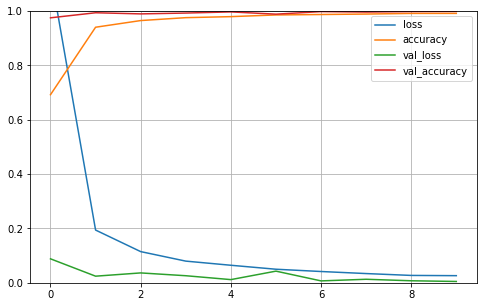

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## Prédiction du modèle

In [21]:
prediction = model.predict_classes(x_test)
print('Test Data accuracy: ',accuracy_score(y_test, prediction))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Test Data accuracy:  0.9802850356294537


## Visualisation via une matrice de confusion

In [22]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(y_test, prediction)

<AxesSubplot:>

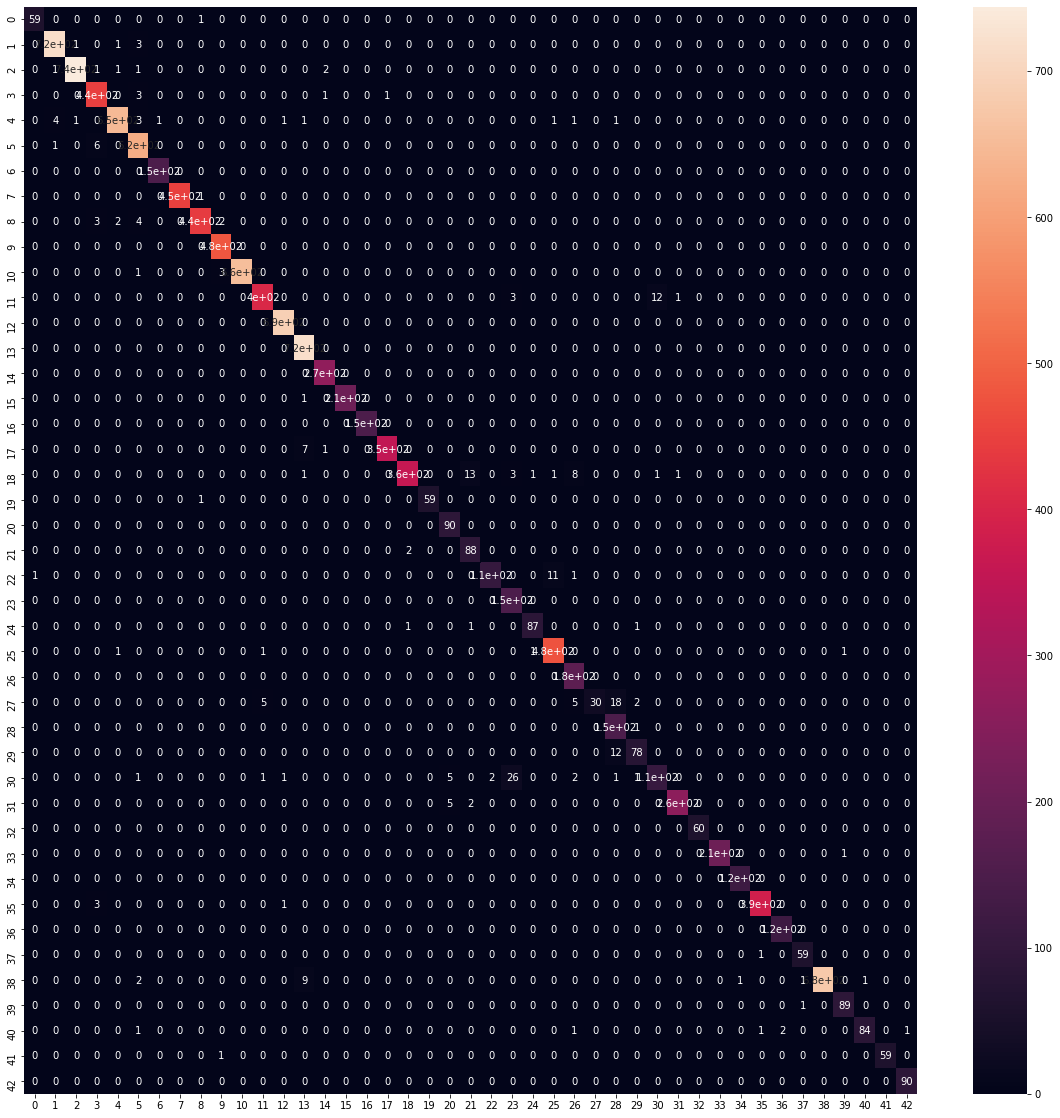

In [23]:


import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)



## Sauvegarde du modèle

In [24]:
model.save('panel_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: panel_model\assets


## Rapport de classification

In [25]:
labels = test["ClassId"].values
from sklearn.metrics import classification_report
print(classification_report(labels, prediction))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        60
           1       0.99      0.99      0.99       720
           2       1.00      0.99      0.99       750
           3       0.97      0.99      0.98       450
           4       0.99      0.98      0.99       660
           5       0.97      0.99      0.98       630
           6       0.99      1.00      1.00       150
           7       1.00      1.00      1.00       450
           8       0.99      0.98      0.98       450
           9       0.99      1.00      0.99       480
          10       1.00      0.99      1.00       660
          11       0.98      0.96      0.97       420
          12       1.00      1.00      1.00       690
          13       0.97      1.00      0.99       720
          14       0.99      1.00      0.99       270
          15       1.00      1.00      1.00       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Prédiction sur le dataset de test

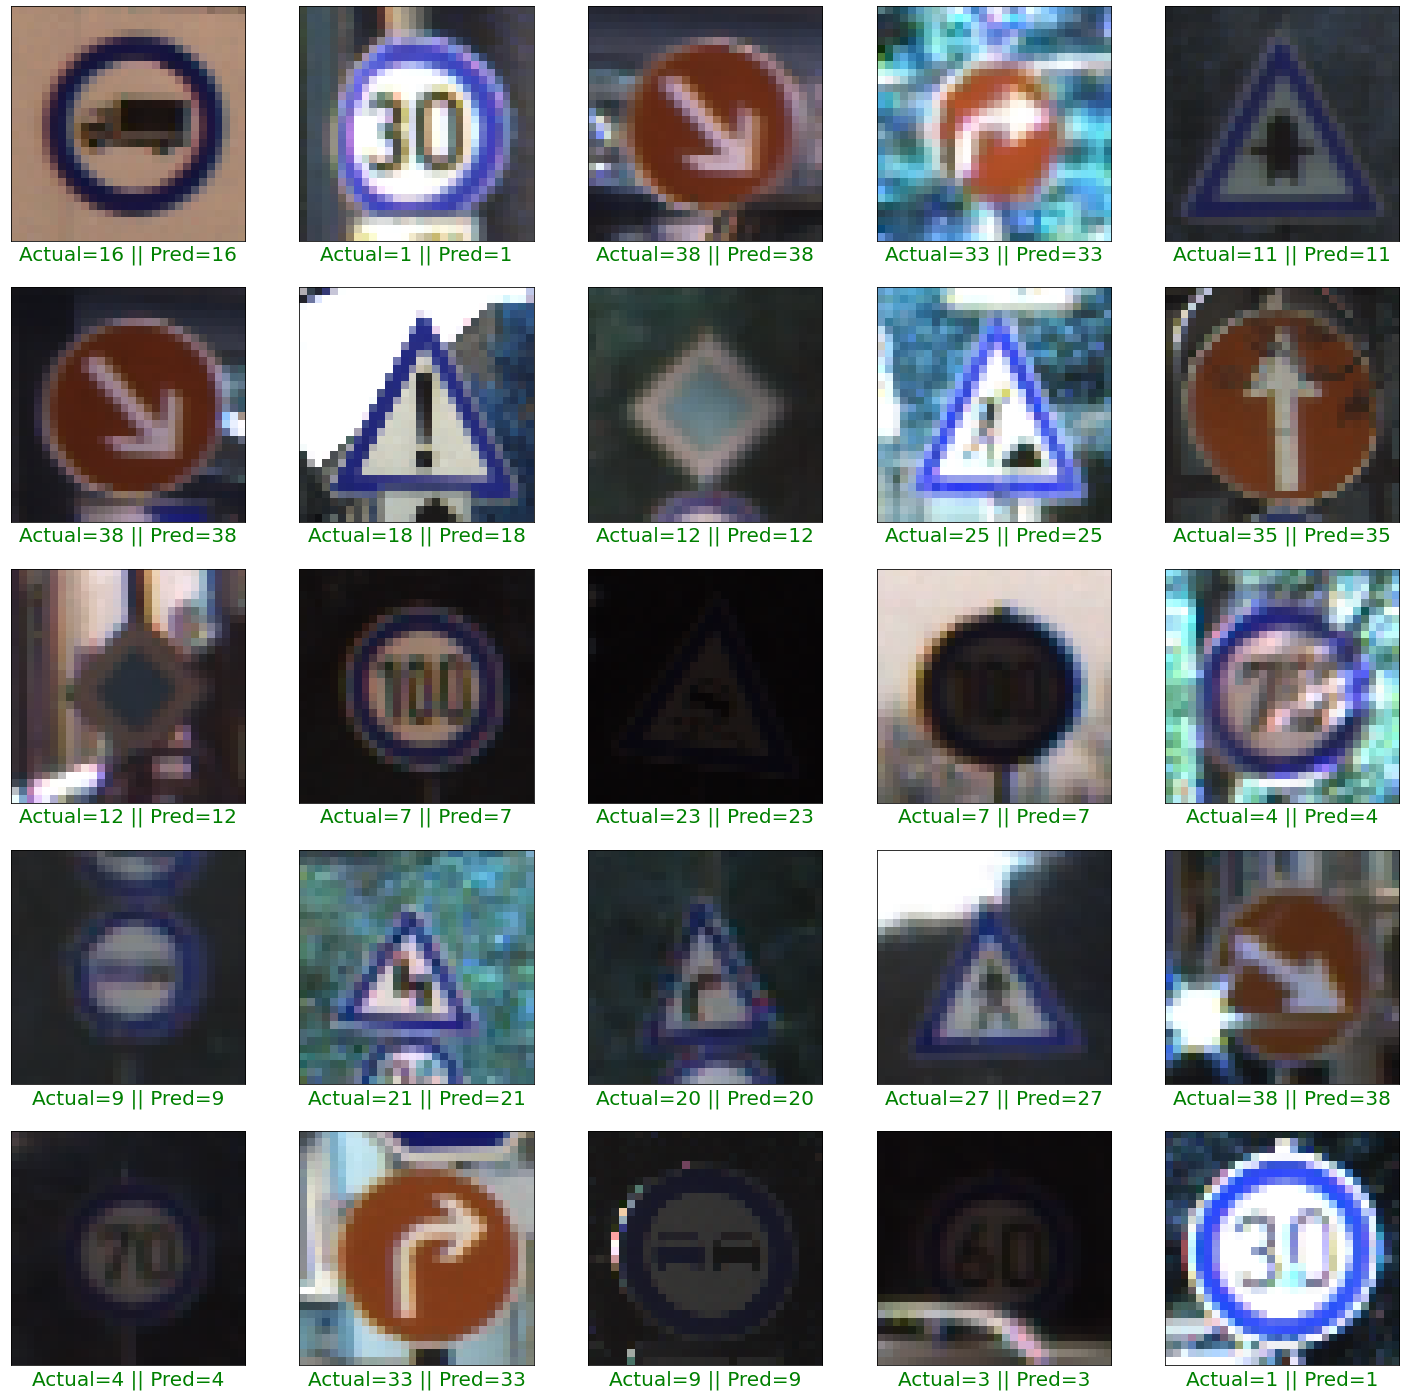

In [26]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = prediction[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, pred), color = col, fontsize=20)
    plt.imshow(x_test[start_index + i])
    

plt.show()

